# Interpolatiing Barium Initial field

In [1]:
import sys
sys.path.insert(0, '_libs/')

In [2]:
import glob
import scipy.io
import numpy as np
import netCDF4 as nc
import NEMO_tools as Nts
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
% matplotlib inline

In [3]:
from pykrige.ok import OrdinaryKriging
import pykrige.kriging_tools as kt

In [4]:
def find_inland(lon, lat):
    '''
    Identify if data points are located in land
    Based on Basemap's GSHHS dataset
    '''
    from mpl_toolkits.basemap import Basemap
    from matplotlib.path import Path
    result = np.empty(lon.shape)
    proj = Basemap(projection='cyl', resolution='l')
    for i in range(np.size(lon, 0)):
        x, y = proj(lon[i, :], lat[i, :])
        locations = np.c_[x, y]
        polygons = [Path(p.boundary) for p in proj.landpolygons]
        row_result = np.zeros(len(locations), dtype=bool) 
        for polygon in polygons:
            row_result += np.array(polygon.contains_points(locations))
        result[i, :] = row_result
    return result

# Kriging interpolation test

In [5]:
x = np.random.random_sample((50,))*10
y = np.random.random_sample((50,))*10
z = x**2 + y**2 + np.random.random_sample((50,))
gridx = np.linspace(x.min(), x.max(), 100)
gridy = np.linspace(y.min(), y.max(), 100)

OK1 = OrdinaryKriging(x, y, z, variogram_model='linear', verbose=False, enable_plotting=False)
out1, ss1 = OK1.execute('grid', gridx, gridy)
# variogram_model: 'gaussian', 'spherical', 'exponential'

<matplotlib.colorbar.Colorbar instance at 0x0000000013C46048>

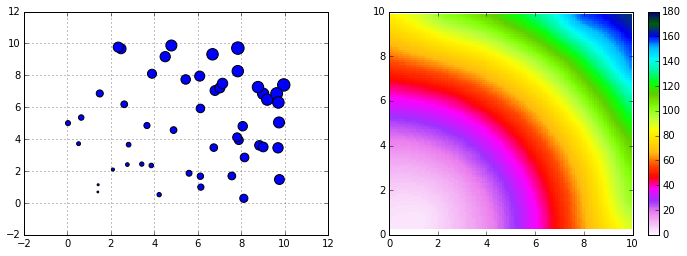

In [6]:
fig = plt.figure(figsize=(12, 4)); ax = fig.gca()
ax1=plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
ax2=plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
ax1.scatter(x, y, z); ax1.grid()
CS = ax2.pcolor(gridx, gridy, out1, cmap=plt.cm.gist_ncar_r, vmin=0,vmax=180); plt.colorbar(CS)

# GIPY11 Ba records

* Data is collected from Jul 2007 to Sep 2007
* I chose CTD depth < 15m as the "surface", since the thickness of ORCA2 grid is 10m 

In [7]:
MAT = scipy.io.loadmat('_data/Samples/GIPY11/GIPY11_Ba.mat')
lons = MAT['Ba_records'][:, 0]
lats = MAT['Ba_records'][:, 1]
deps = MAT['Ba_records'][:, 2]
Ba   = MAT['Ba_records'][:, 3]

** Get Ba @ surface **

In [8]:
hit = deps < 15
lon_surf = lons[hit]; lat_surf = lats[hit]; Ba_surf  = Ba[hit]
_, indices = np.unique(lon_surf, return_index=True)
x = lon_surf[indices]; y = lat_surf[indices]; z = Ba_surf[indices]
len(x)

36

36 points in total

**Kriging interpolation**

In [9]:
listx = np.linspace(x.min()-10, x.max()+2.5, 100)
listy = np.linspace(y.min()-2.5, 90, 100)
gridx, gridy = np.meshgrid(listx, listy)

In [10]:
OK = OrdinaryKriging(x, y, z, variogram_model='linear', verbose=False, enable_plotting=False)
Ba_int, ss = OK.execute('grid', listx, listy)

**Remap on ORCA2 frame**

In [11]:
coordinate_name=glob.glob('_data/NEMO/ORCA2_INPUT/coordinates*.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]
# The original data is 0 - 360
nav_lon[nav_lon<0]=nav_lon[nav_lon<0]+360

In [12]:
Ba_ini_orca = Nts.reporj_NEMOgrid(gridx, gridy, Ba_int, nav_lon, nav_lat, method='linear')

In [13]:
hit = find_inland(nav_lon, nav_lat); Ba_ini_orca[hit==1]=np.nan
Ba_ini_masked = np.ma.masked_where(np.isnan(Ba_ini_orca), Ba_ini_orca)

In [14]:
# convert back to -180 - 180
nav_lon[nav_lon>180]=nav_lon[nav_lon>180]-360

# Plot

In [15]:
ETOPO2_Arctic=scipy.io.loadmat('_libs/ETOPO2_Arctic.mat')
lon_arctic=ETOPO2_Arctic['lon_arctic']
lat_arctic=ETOPO2_Arctic['lat_arctic']
topo_arctic=ETOPO2_Arctic['topo_arctic']

In [16]:
# Adjust resolution
res_unit=5
lon_arctic=lon_arctic[0:-1:res_unit, 0:-1:res_unit]
lat_arctic=lat_arctic[0:-1:res_unit, 0:-1:res_unit]
topo_arctic=topo_arctic[0:-1:res_unit, 0:-1:res_unit]*-1

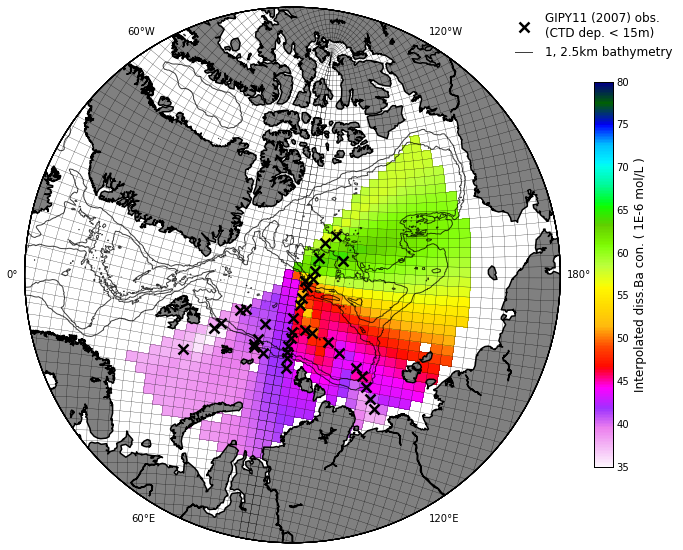

In [17]:
clevs=[1000, 2500]
fig=plt.figure(figsize=(12, 12)); ax=plt.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=65, lon_0=90, round=True, ax=ax)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=1.5, color='k')
gridx, gridy = proj(nav_lon, nav_lat)
locx, locy = proj(x, y)
topox, topoy = proj(lon_arctic, lat_arctic)
CS = proj.pcolor(gridx, gridy, Ba_ini_masked, vmin=35, vmax=80, cmap=plt.cm.gist_ncar_r)
CS2 = proj.contour(topox, topoy, topo_arctic, clevs, linestyles='-', linewidths=1, colors=('k',), alpha=0.75)
CS2.collections[0].set_label('1, 2.5km bathymetry')
proj.plot(gridx.T, gridy.T, 'k-', lw=0.25)
proj.plot(gridx, gridy, 'k-', lw=0.25)
proj.plot(locx, locy, 'kx', ms=10, mew=2.5, label='GIPY11 (2007) obs.\n(CTD dep. < 15m)'); 
CBar = plt.colorbar(CS, shrink=0.575)
CBar.set_label('Interpolated diss.Ba con. ( 1E-6 mol/L )', fontsize=12)
CBar.ax.tick_params(axis='y', length=0)
LG = ax.legend(numpoints=1, bbox_to_anchor=(0.9, 1), loc=2, borderaxespad=0.); LG.draw_frame(False)
fig.savefig('Publish/Barium_4.pdf', dpi=600, orientation='portrait', papertype='a4', format='pdf',
            transparent=False, bbox_inches='tight', pad_inches=0)

**Compare with Guay (1997)'s work'**

<img src="_figures/Gauy_Ba_map.PNG" width=650 align="left"/>